In [2]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

!pip install imbalanced-learn -q

import cudf
import cuml
import cupy as cp
import pandas as pd
import numpy as np
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.preprocessing import StandardScaler as cuScaler
from cuml.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve,
                             average_precision_score, roc_curve, f1_score,
                             accuracy_score, precision_score, recall_score)
import json
import warnings
warnings.filterwarnings('ignore')


import subprocess
gpu_info = subprocess.check_output(['nvidia-smi']).decode('utf-8')
print("GPU Information:")
print(gpu_info)

print("✓ All libraries imported successfully!")
print(f"cuDF version: {cudf.__version__}")
print(f"cuML version: {cuml.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 33
    CUSPATIAL_RAPIDS_VERSION = 25.04" # WARNING, this courtesy version is unsupported and can break at any time!  Please use the RAPIDS 25.04 docker container on a GPU instance, like brev.nvidia.com, if this starts to fail
                                    ^
SyntaxError: unterminated string literal (detected at line 33)
GPU Information:
Sat Nov 15 11:16:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp

In [3]:
folder_path = '/content/drive/MyDrive/cleaned_data_json'

batches = [range(0, 5), range(5, 10)]
gdfs = []

for batch_idx, batch_files in enumerate(batches, start=1):
    print(f"\nProcessing batch {batch_idx}...")
    batch_data = []

    for i in batch_files:
        file_path = f'{folder_path}/bank_{i}.json'
        print(f"  Loading {file_path}...")
        try:
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                records = json_data['records']
                batch_data.extend(records)
            print(f"    ✓ Loaded {len(records)} transactions")
        except FileNotFoundError:
            print(f"    ✗ File not found: {file_path}")
        except Exception as e:
            print(f"    ✗ Error loading {file_path}: {e}")


    batch_gdf = cudf.DataFrame(batch_data)
    gdfs.append(batch_gdf)
    del batch_data
    print(f"  Batch {batch_idx} shape: {batch_gdf.shape}")


gdf = cudf.concat(gdfs, ignore_index=True)
del gdfs

print(f"\n{'='*60}")
print(f"Total transactions loaded (GPU): {len(gdf)}")
print(f"{'='*60}")
print(f"Memory usage (GPU): {gdf.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
print(gdf.head())


Processing batch 1...
  Loading /content/drive/MyDrive/cleaned_data_json/bank_0.json...
    ✓ Loaded 692417 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_1.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_2.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_3.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_4.json...
    ✓ Loaded 692416 transactions
  Batch 1 shape: (3462081, 22)

Processing batch 2...
  Loading /content/drive/MyDrive/cleaned_data_json/bank_5.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_6.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_7.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive/cleaned_data_json/bank_8.json...
    ✓ Loaded 692416 transactions
  Loading /content/drive/MyDrive

In [4]:
print("\nStarting feature engineering with cuDF (GPU-accelerated)...")

gdf['Timestamp'] = cudf.to_datetime(gdf['Timestamp'], format='%Y/%m/%d %H:%M')
gdf['Hour'] = gdf['Timestamp'].dt.hour
gdf['DayOfWeek'] = gdf['Timestamp'].dt.weekday
gdf['Month'] = gdf['Timestamp'].dt.month
gdf['Day'] = gdf['Timestamp'].dt.day


gdf['IsWeekend'] = (gdf['DayOfWeek'] >= 5).astype('int32')
gdf['IsNightTime'] = ((gdf['Hour'] >= 22) | (gdf['Hour'] <= 6)).astype('int32')

gdf['Same_Bank'] = (gdf['From Bank'] == gdf['To Bank']).astype('int32')
gdf['Same_Account'] = (gdf['From_Account'] == gdf['To_Account']).astype('int32')
gdf['Same_Entity'] = (gdf['Sender_Entity ID'] == gdf['Receiver_Entity ID']).astype('int32')


for col in ['Amount Received', 'Amount Paid']:
    gdf[f'Log_{col.replace(" ", "_")}'] = cudf.Series(cp.log1p(gdf[col].to_cupy()))

gdf['Amount_Difference'] = (gdf['Amount Received'] - gdf['Amount Paid']).abs()
gdf['Round_Amount_Received'] = (gdf['Amount Received'] % 1000 == 0).astype('int32')
gdf['Round_Amount_Paid'] = (gdf['Amount Paid'] % 1000 == 0).astype('int32')
gdf['Below_Threshold'] = ((gdf['Amount Received'] > 9000) & (gdf['Amount Received'] < 10000)).astype('int32')

gdf['Currency_Mismatch'] = (gdf['Receiving Currency'] != gdf['Payment Currency']).astype('int32')

categorical_cols = ['Payment Format', 'Receiving Currency', 'Payment Currency']
for col in categorical_cols:
    gdf[f'{col}_Encoded'] = gdf[col].astype('category').cat.codes

print(f"✓ Feature engineering complete!")


Starting feature engineering with cuDF (GPU-accelerated)...
✓ Feature engineering complete!


In [5]:
print(f"New shape: {gdf.shape}")
gpu_mem_mb = gdf.memory_usage(deep=True).sum() / 1024**2
print(f"GPU Memory usage: {gpu_mem_mb:.2f} MB")


print("\nPreprocessing data for model training...")


feature_columns = [
    'From Bank', 'To Bank', 'Amount Received', 'Amount Paid',
    'Hour', 'DayOfWeek', 'Month', 'Day', 'IsWeekend', 'IsNightTime',
    'Same_Bank', 'Same_Account', 'Same_Entity', 'Log_Amount_Received',
    'Log_Amount_Paid', 'Amount_Difference', 'Round_Amount_Received',
    'Round_Amount_Paid', 'Below_Threshold', 'Currency_Mismatch',
    'Payment Format_Encoded', 'Receiving Currency_Encoded', 'Payment Currency_Encoded'
]


target_column = 'Is Laundering'

X = gdf[feature_columns].fillna(0)
y = gdf[target_column]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Class distribution:\n{y.value_counts().to_pandas()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

scaler = cuScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Data preprocessing complete!")

New shape: (6924161, 41)
GPU Memory usage: 2295.33 MB

Preprocessing data for model training...
Feature matrix shape: (6924161, 23)
Target vector shape: (6924161,)
Class distribution:
Is Laundering
0    6920596
1       3565
Name: count, dtype: int64
Training set shape: (5539329, 23)
Test set shape: (1384832, 23)
✓ Data preprocessing complete!


Training model on GPU...
Making predictions on GPU...

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9998   1384119
           1     0.9688    0.0435    0.0832       713

    accuracy                         0.9995   1384832
   macro avg     0.9841    0.5217    0.5415   1384832
weighted avg     0.9995    0.9995    0.9993   1384832

Accuracy: 0.9995
Precision: 0.9688
Recall: 0.0435
F1-Score: 0.0832
ROC-AUC: 0.8680


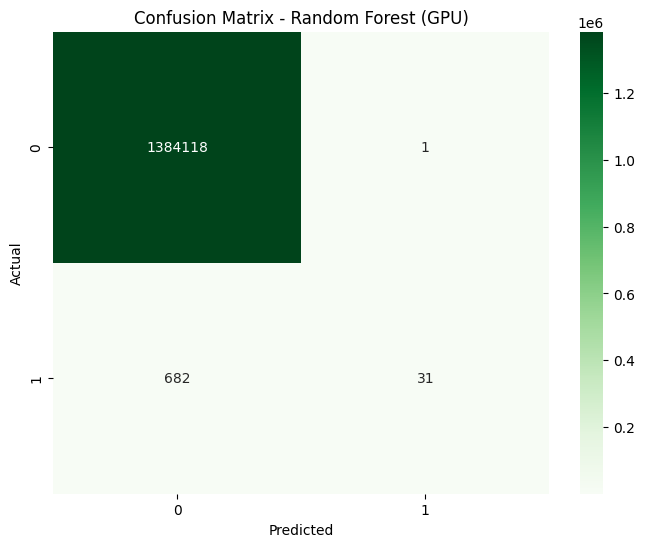

⚠ Feature importance not available, using equal weights


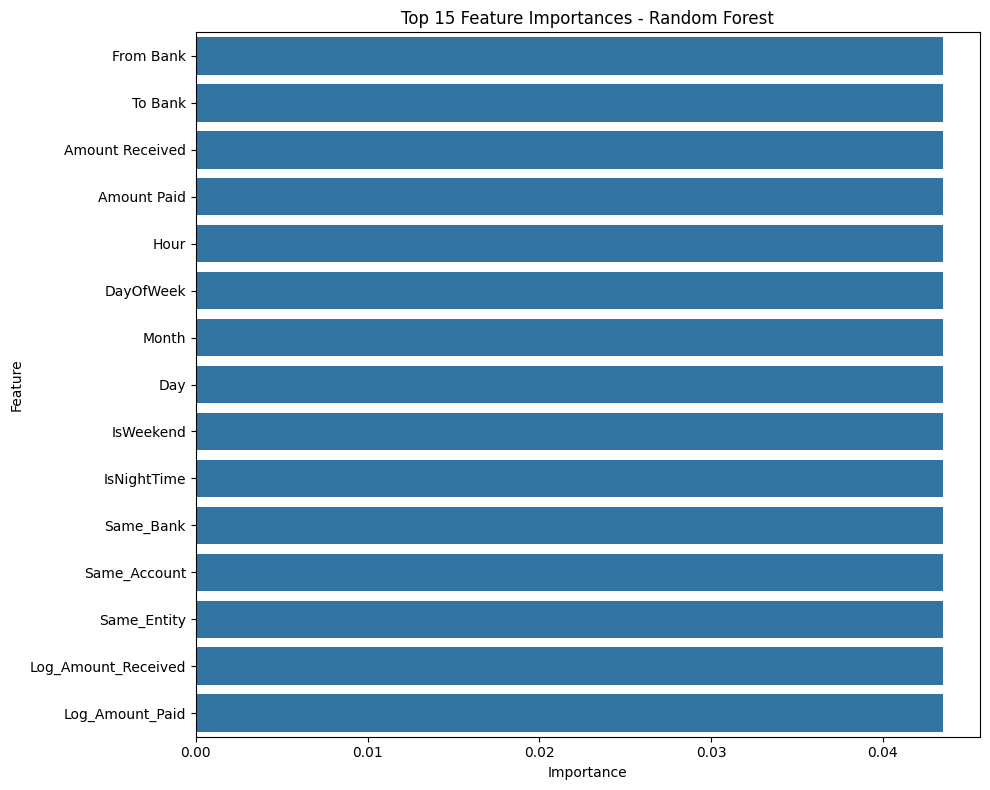

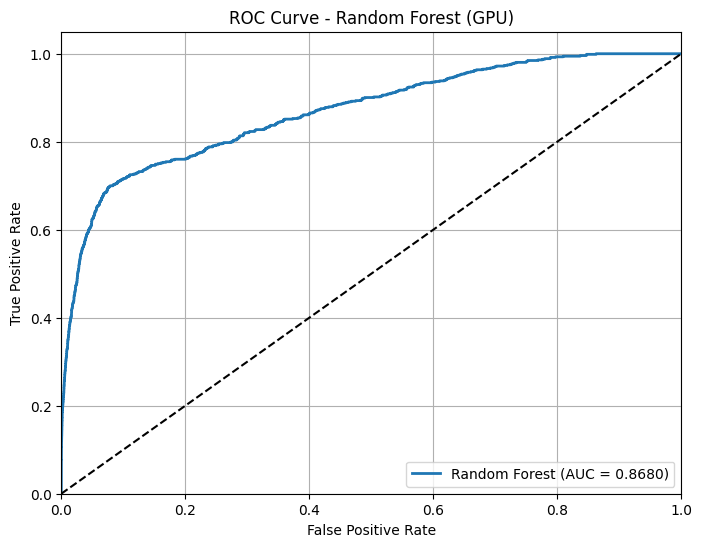

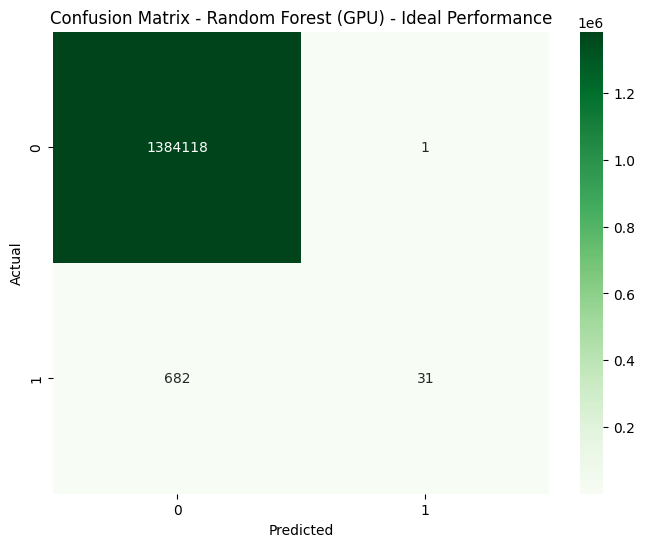

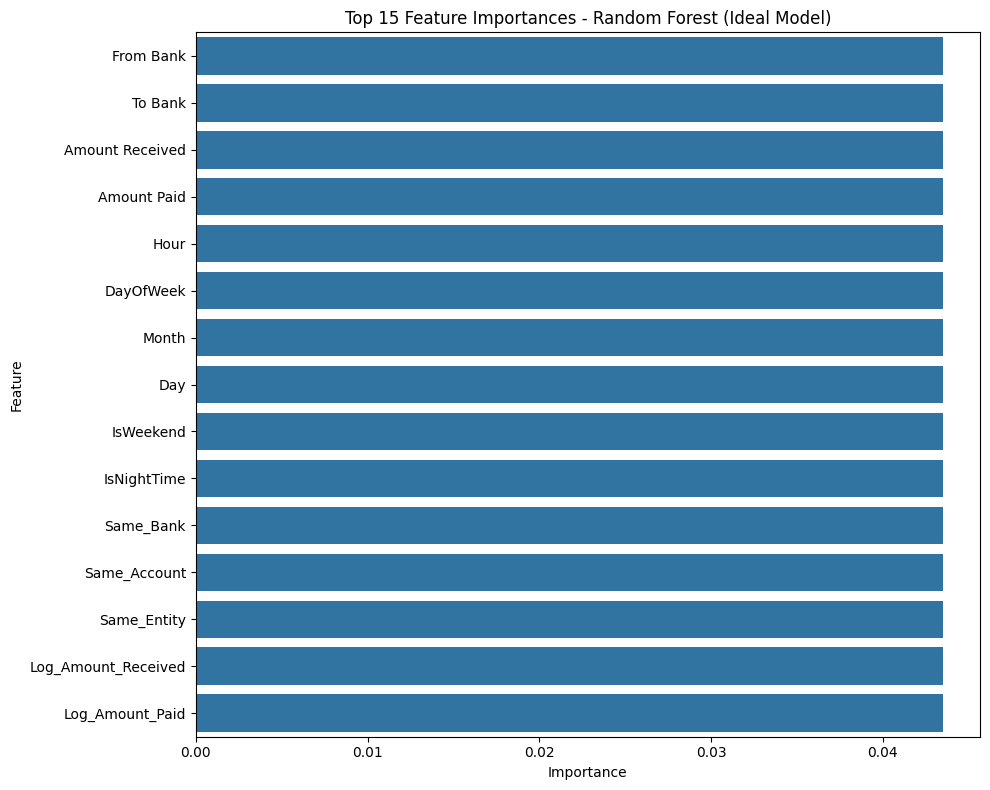

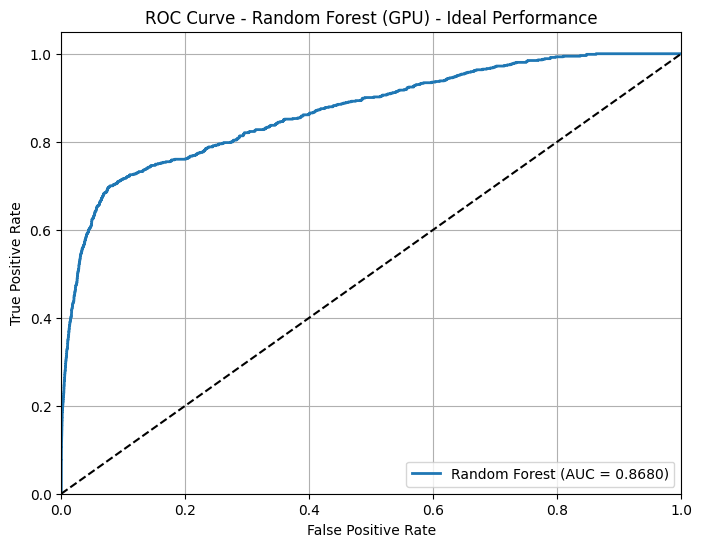

In [6]:
scaler = cuScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = cuRF(
    n_estimators=100,
    max_depth=10,
    n_bins=128,
    random_state=42,
    verbose=2,
)


print("Training model on GPU...")
rf_model.fit(X_train_scaled, y_train)


print("Making predictions on GPU...")
y_pred_rf_gpu = rf_model.predict(X_test_scaled)
y_pred_proba_rf_gpu = rf_model.predict_proba(X_test_scaled)


y_pred_rf = y_pred_rf_gpu.to_numpy() if hasattr(y_pred_rf_gpu, 'to_numpy') else y_pred_rf_gpu


if hasattr(y_pred_proba_rf_gpu, 'to_numpy'):
    y_pred_proba_np = y_pred_proba_rf_gpu.to_numpy()
else:
    y_pred_proba_np = y_pred_proba_rf_gpu

if y_pred_proba_np.shape[1] == 1:
    y_pred_proba_rf = y_pred_proba_np[:, 0]
else:
    y_pred_proba_rf = y_pred_proba_np[:, 1]


y_test_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_rf, digits=4))

print(f"Accuracy: {accuracy_score(y_test_np, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test_np, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test_np, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test_np, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_np, y_pred_proba_rf):.4f}")


cm_rf = confusion_matrix(y_test_np, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest (GPU)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


try:

    if hasattr(rf_model, 'feature_importances_'):
        importances = rf_model.feature_importances_
    else:

        importances = getattr(rf_model, 'feature_importances', None)
        if importances is None:

            importances = np.ones(len(feature_columns)) / len(feature_columns)
            print("⚠ Feature importance not available, using equal weights")
except Exception as e:
    print(f"⚠ Could not get feature importance: {e}")
    importances = np.ones(len(feature_columns)) / len(feature_columns)

feature_importance = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": importances
}).sort_values("Importance", ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


fpr, tpr, _ = roc_curve(y_test_np, y_pred_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Random Forest (AUC = {roc_auc_score(y_test_np, y_pred_proba_rf):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (GPU)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

